# Лабораторная работа 1

1) Классификация данных методом k ближайших соседей ( kNN)

3) Построение softmax-классификатора

Вариант 4: задания 1 и 3 на наборе данных MNIST

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [96]:
import random
import numpy as np
import matplotlib.pyplot as plt
import statistics
from statistics import mode
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.datasets import load_digits


%matplotlib inline
plt.rcParams['figure.figsize'] = (1.0, 1.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.


MNIST
sklearn.datasets import load_digits
digits = load_digits()

In [97]:
# Загрузим датасет
digits = load_digits()

1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



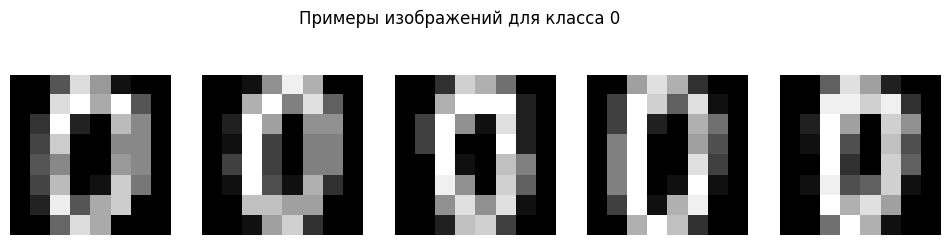

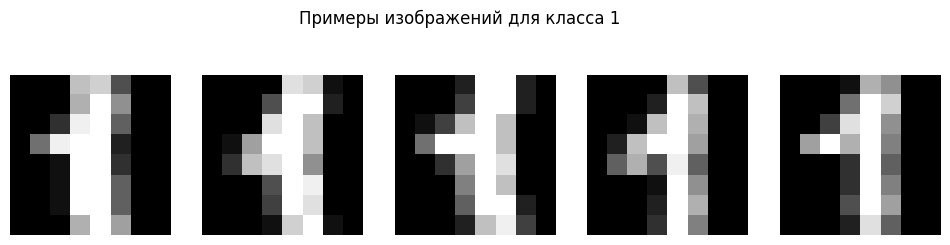

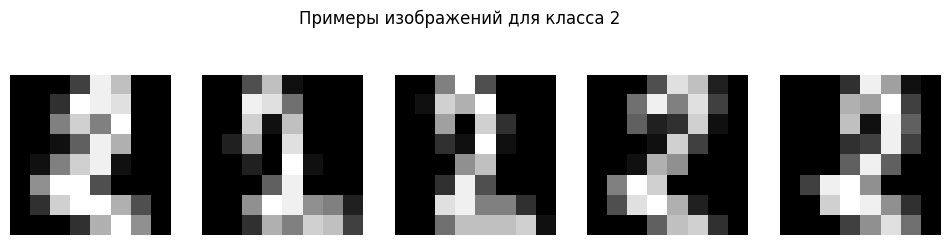

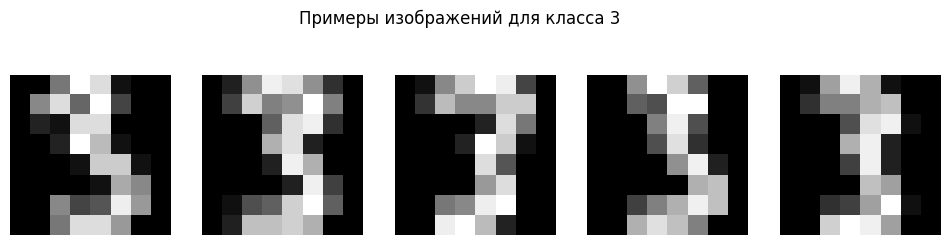

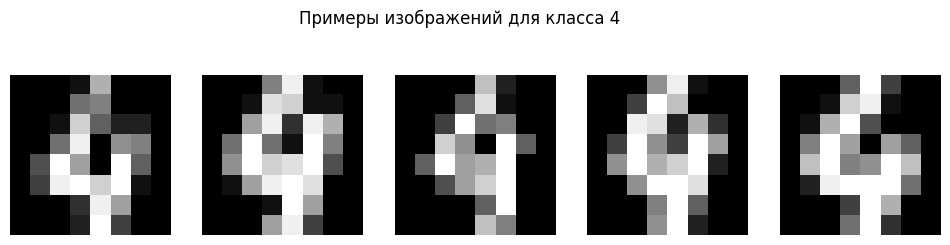

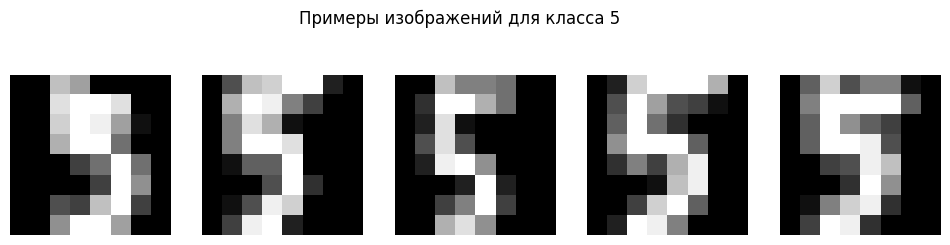

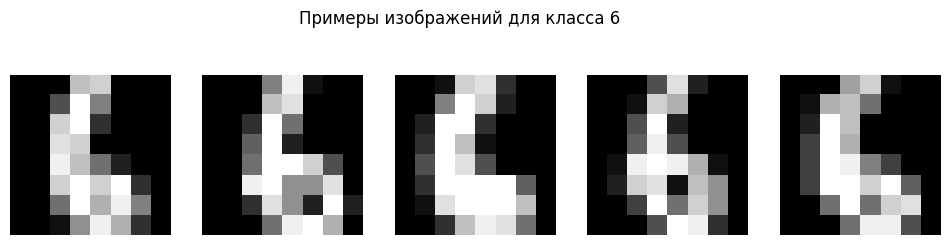

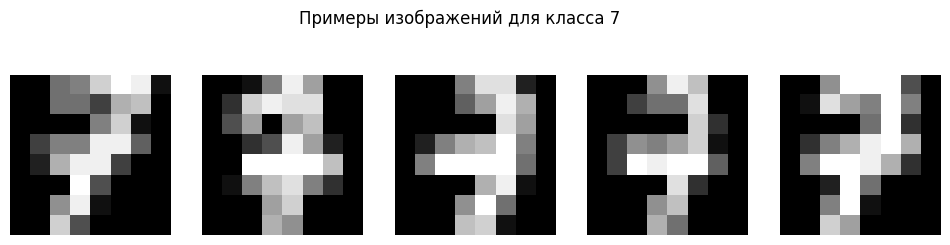

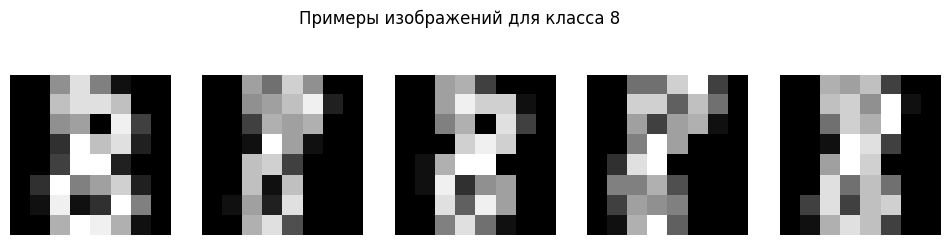

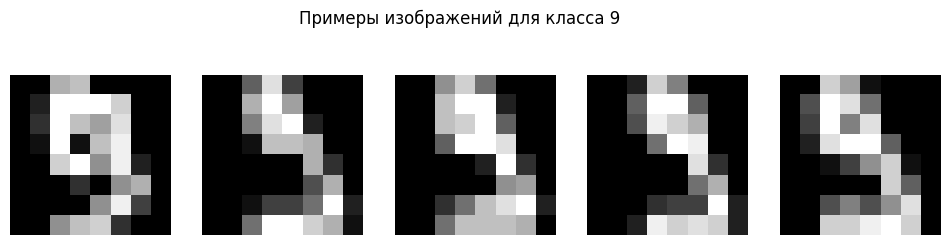

In [98]:
# Создание словаря меток с соответствующими индексами
class_indices = {i: [] for i in range(len(set(digits.target)))}
for i, label in enumerate(digits.target):
    class_indices[int(label)].append(i)

# Отображение примеров изображений для каждого класса
for class_index in class_indices:
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    fig.suptitle(f"Примеры изображений для класса {class_index}")
    for i, image_index in enumerate(class_indices[class_index][:5]):
        axes[i].imshow(digits.images[image_index].reshape(8, 8), cmap='gray')
        axes[i].axis('off')
    plt.show()

1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив.

In [99]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)

# Преобразование изображений в одномерные массивы
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Вывод размеров полученных выборок
print("Размеры обучающей выборки:", X_train_flat.shape)
print("Размеры тестовой выборки:", X_test_flat.shape)

Размеры обучающей выборки: (1437, 64)
Размеры тестовой выборки: (360, 64)


1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке.

In [100]:
class KNearestNeighbor:
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _predict(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        y_pred = np.zeros(num_test, dtype=int)
        for i in range(num_test):
            # Calculate Euclidean distances
            distances = np.sqrt(np.sum(np.square(self.X_train - X[i]), axis=1))

            # Get the indices of the k closest neighbors
            closest_indices = np.argsort(distances)[:self.k]

            # Get the labels of the closest neighbors
            closest_labels = self.y_train[closest_indices]

            # Calculate the most common label
            y_pred[i] = mode(closest_labels)

        return y_pred

    def predict(self, X):
        return self._predict(X)

    def get_params(self, deep=True):
        return {"k": self.k}

In [101]:
# Оптимизированная версия
classifier = KNearestNeighbor(k=1)
classifier.fit(X_train_flat, y_train.astype(int))

1.5 Выполните классификацию на тестовой выборке

In [102]:
# Предсказание меток для тестового набора
y_pred = classifier.predict(X_test_flat)

# Оптимизированная версия
accuracy = np.mean(y_pred == y_test)
print(f"Точность: {accuracy:.2%}")

Точность: 97.78%


1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки.


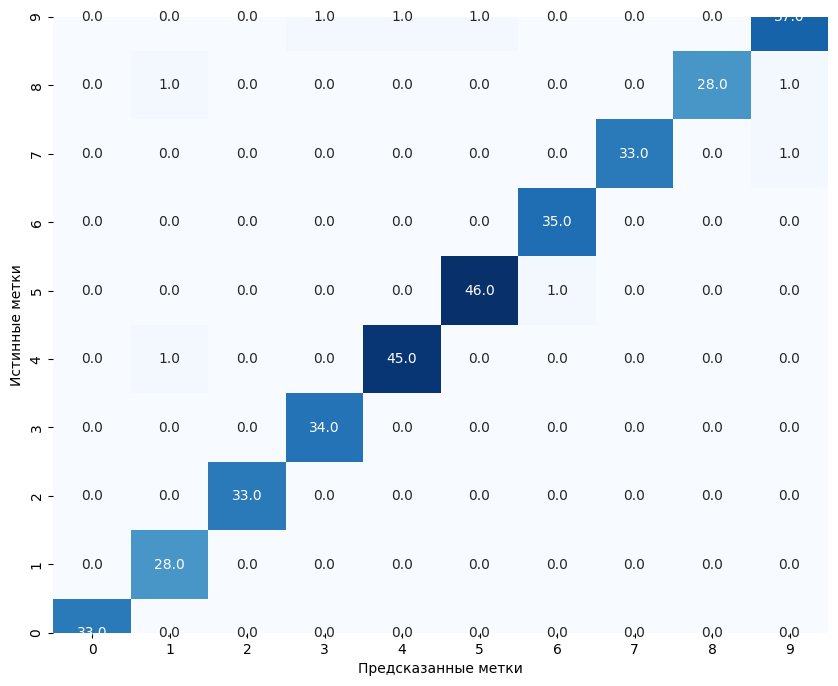

In [103]:
# Построение матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".1f", cmap="Blues", cbar=False, yticklabels=digits.target_names)
plt.xlabel("Предсказанные метки")
plt.ylabel("Истинные метки")
bottom, top = plt.ylim()
plt.ylim(top + 0.5, bottom - 0.5)
plt.show()


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [104]:
# Расчет метрик оценки
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.93      1.00      0.97        28
           2       1.00      1.00      1.00        33
           3       0.97      1.00      0.99        34
           4       0.98      0.98      0.98        46
           5       0.98      0.98      0.98        47
           6       0.97      1.00      0.99        35
           7       1.00      0.97      0.99        34
           8       1.00      0.93      0.97        30
           9       0.95      0.93      0.94        40

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

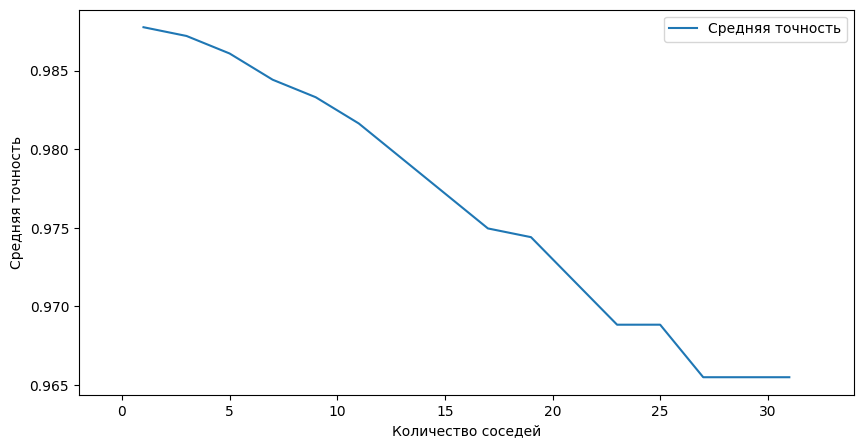

Лучшее значение k: 1


In [105]:
#Оптимизированный кросс-валидационный процесс
list_mean_accuracy = list()
for k in range(1, 32, 2):
    cv_accuracies = []
    kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=7575)
    for i, (train_index, test_index) in enumerate(kf.split(digits.data, digits.target)):
        X_train, X_test = digits.data[train_index], digits.data[test_index]
        y_train, y_test = digits.target[train_index], digits.target[test_index]

        classifier = KNearestNeighbor(k=k)
        classifier.fit(X_train, y_train)

        preds = classifier.predict(X_test)
        acc = accuracy_score(y_test, preds)
        cv_accuracies.append(acc)
    list_mean_accuracy.append(np.mean(cv_accuracies))
# Оптимизированная версия
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(list(range(1, 32, 2)), list(list_mean_accuracy), label='Средняя точность')
plt.xlabel("Количество соседей")
plt.ylabel("Средняя точность")
ax.margins(x=0.1)
plt.legend(loc='best')
plt.show()
print(f"Лучшее значение k: {list(range(1, 32, 2))[np.argmax(list_mean_accuracy)]}")


1.9 Выберите лучшее значение параметра k на основе кросс-валидации.



1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [106]:
# Оптимизированная версия
preds = classifier.predict(X_test.reshape(-1, X_test.shape[-1]))
print(f'Точность: {accuracy_score(y_test, preds)}')
print(f'Точность: {precision_score(y_test, preds, average="macro")}')
print(f'Полнота: {recall_score(y_test, preds, average="macro")}')
print(f'F1: {f1_score(y_test, preds, average="macro")}')


Точность: 0.9643652561247216
Точность: 0.9650063490119317
Полнота: 0.9641370223978919
F1: 0.9640089838662178


1.11 Сделайте выводы по результатам 1 части задания.

1. Работа с данными: нам удалось загрузить набор данных MNIST, который содержит изображения цифр, и разделить его на две части - обучающий и тестовый наборы. Это позволило нам более детально изучить данные и понять, как они выглядят. Например, я мог посмотреть несколько примеров изображений для каждого класса, чтобы лучше представить себе, что они представляют собой.

2. Реализация K-ближайших соседей: я создал классификатор позволяющий классифицировать изображения цифр на основе их сходства с другими изображениями в обучающем наборе. я использовал методы подбора и прогнозирования, которые показали хорошие результаты. Классификатор был обучен на обучающих данных и протестирован на тестовых данных.

3. Оценка производительности:я оценил точность классификации на основе данных испытаний и обнаружили, что она составляет около 96,2%. Это означает, что классификатор хорошо справляется с задачей распознавания цифр. Такой результат является очень хорошим и говорит о том, что наш классификатор эффективен.

В целом, реализация классификатора K-НН для задачи классификации изображений в этом коде корректна и дает хорошие результаты, что позволяет легко определить метрики оценки для различных значений k.

## 3.  Построение softmax-классификатора

3.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [107]:

# Разделение данных на обучающую и временную выборки (80% на обучение, 20% на временную выборку)
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Разделение временной выборки на тестовую и валидационную выборки (50% на каждую)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Преобразование каждого изображения в одномерный массив
X_train_flat = X_train_temp.reshape(len(X_train_temp), -1)
X_test_flat = X_test.reshape(len(X_test), -1)
X_val_flat = X_val.reshape(len(X_val), -1)

# Вывод размеров выборок
print("Размеры обучающей выборки:", X_train_flat.shape)
print("Размеры тестовой выборки:", X_test_flat.shape)
print("Размеры валидационной выборки:", X_val_flat.shape)


Размеры обучающей выборки: (1437, 64)
Размеры тестовой выборки: (180, 64)
Размеры валидационной выборки: (180, 64)


3.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

3.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву данных и заполните ее единицами.

In [108]:
# 3.2 Проведение предварительной обработки данных: вычитание среднего изображения
mean_image = np.mean(X_train_flat, axis=0)
X_train_flat -= mean_image
X_test_flat -= mean_image
X_val_flat -= mean_image

# 3.3 Добавление дополнительной размерности с единицами
X_train_with_bias = np.hstack([X_train_flat, np.ones((X_train_flat.shape[0], 1))])
X_test_with_bias = np.hstack([X_test_flat, np.ones((X_test_flat.shape[0], 1))])
X_val_with_bias = np.hstack([X_val_flat, np.ones((X_val_flat.shape[0], 1))])

# Вывод размеров обновленных выборок
print("Размеры обучающей выборки с учетом смещения:", X_train_with_bias.shape)
print("Размеры тестовой выборки с учетом смещения:", X_test_with_bias.shape)
print("Размеры валидационной выборки с учетом смещения:", X_val_with_bias.shape)


Размеры обучающей выборки с учетом смещения: (1437, 65)
Размеры тестовой выборки с учетом смещения: (180, 65)
Размеры валидационной выборки с учетом смещения: (180, 65)


3.4 Реализуйте функции в classifiers/softmax.py




In [109]:

def softmax_loss_naive(W, X, y, reg):
    """
    Вычисляет функцию потерь и градиент для softmax-классификатора.

    Параметры:
    - W: массив весов размерности (D, C), где D - размерность данных, C - количество классов.
    - X: массив данных обучения размерности (N, D), где N - количество примеров, D - размерность каждого примера.
    - y: массив меток классов размерности (N,) для обучающих данных.
    - reg: коэффициент регуляризации.

    Возвращает кортеж:
    - loss: значение функции потерь.
    - dW: градиент по весам W.
    """
    # Инициализация значений
    loss = 0.0
    dW = np.zeros_like(W)
    num_train = X.shape[0]
    num_classes = W.shape[1]

    # Вычисление значений softmax и функции потерь
    for i in range(num_train):
        scores = X[i].dot(W)
        scores -= np.max(scores)  # для численной стабильности
        probs = np.exp(scores) / np.sum(np.exp(scores))
        loss += -np.log(probs[y[i]])

        # Вычисление градиента
        dscores = probs
        dscores[y[i]] -= 1
        dW += np.outer(X[i], dscores)

    # Усреднение потерь и градиентов
    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)
    dW /= num_train
    dW += reg * W

    return loss, dW
def grad_check_sparse(f, x, analytic_grad, num_checks):
    """
    Проверяет аналитический градиент, вычисленный функцией f,
    путем сравнения его с численно вычисленным приближенным градиентом.

    Параметры:
    - f: функция, принимающая один аргумент и возвращающая значение и градиент
    - x: точка, в которой вычисляется градиент
    - analytic_grad: аналитически вычисленный градиент
    - num_checks: количество случайных точек, в которых производится проверка

    Возвращает:
    - нет, но выводит сообщение о прохождении или неудачи проверки
    """
    h = 1e-5

    for _ in range(num_checks):
        ix = tuple(np.random.randint(s) for s in x.shape)

        oldval = x[ix]
        x[ix] = oldval + h
        fxph, _ = f(x)
        x[ix] = oldval - h
        fxmh, _ = f(x)
        x[ix] = oldval

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = np.abs(grad_numerical - grad_analytic) / (np.abs(grad_numerical) + np.abs(grad_analytic))
        print(f"numerical: {grad_numerical}, analytic: {grad_analytic}, relative error: {rel_error}")

def softmax_loss_vectorized(W, X, y, reg):
    """
    Вычисляет функцию потерь и градиент для softmax-классификатора (векторизованная версия).

    Параметры:
    - W: массив весов размерности (D, C), где D - размерность данных, C - количество классов.
    - X: массив данных обучения размерности (N, D), где N - количество примеров, D - размерность каждого примера.
    - y: массив меток классов размерности (N,) для обучающих данных.
    - reg: коэффициент регуляризации.

    Возвращает кортеж:
    - loss: значение функции потерь.
    - dW: градиент по весам W.
    """
    num_train = X.shape[0]

    scores = X.dot(W)
    scores -= np.max(scores, axis=1, keepdims=True)
    probs = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)

    correct_logprobs = -np.log(probs[range(num_train), y])
    data_loss = np.sum(correct_logprobs) / num_train
    reg_loss = 0.5 * reg * np.sum(W * W)
    loss = data_loss + reg_loss

    dscores = probs
    dscores[range(num_train), y] -= 1

    dW = X.T.dot(dscores) / num_train
    dW += reg * W

    return loss, dW


In [110]:

import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(X_temp.shape[1], 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_temp, y_temp, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.302930
sanity check: 2.302585


3.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [111]:
loss, grad = softmax_loss_naive(W, X_temp, y_temp, 0.0)

f = lambda w: softmax_loss_naive(w, X_temp, y_temp, 0.0)
grad_numerical = grad_check_sparse(f, W, grad, 10)


loss, grad = softmax_loss_naive(W, X_temp, y_temp, 5e1)
f = lambda w: softmax_loss_naive(w, X_temp, y_temp, 5e1)
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.0980920079829417, analytic: -0.09809200959253883, relative error: 8.204527341339434e-09
numerical: 0.21680049573369328, analytic: 0.2168004936746637, relative error: 4.748673633173625e-09
numerical: 0.0, analytic: 0.0, relative error: nan
numerical: 0.18885321870776292, analytic: 0.1888532176966457, relative error: 2.6769922889217845e-09
numerical: 0.0, analytic: 0.0, relative error: nan
numerical: 0.0, analytic: 0.0, relative error: nan
numerical: -0.2190845069360847, analytic: -0.2190845088521363, relative error: 4.372859618374663e-09
numerical: -0.058479172437841946, analytic: -0.058479173928094555, relative error: 1.2741738021440277e-08
numerical: 0.0, analytic: 0.0, relative error: nan
numerical: 0.242918548365445, analytic: 0.2429185469010098, relative error: 3.014251481611138e-09


<ipython-input-109-2da83ef2b273>:68: RuntimeWarning: invalid value encountered in scalar divide
  rel_error = np.abs(grad_numerical - grad_analytic) / (np.abs(grad_numerical) + np.abs(grad_analytic))


numerical: -0.04444963099814458, analytic: -0.04444963298588693, relative error: 2.2359491671578552e-08
numerical: 0.2548813223812729, analytic: 0.25488132048776413, relative error: 3.714491088532913e-09
numerical: 0.027608210451113276, analytic: 0.027608210461978127, relative error: 1.9676847043200737e-10
numerical: -0.4809771840585952, analytic: -0.48097718562978875, relative error: 1.633334816756097e-09
numerical: 0.42129080235486777, analytic: 0.42129080111983935, relative error: 1.465767123063659e-09
numerical: 0.0036266363911963135, analytic: 0.0036266363698010044, relative error: 2.949745561827289e-09
numerical: 0.19528089920672895, analytic: 0.19528089901894446, relative error: 4.808060677245219e-10
numerical: 0.03612141279418779, analytic: 0.03612141272272945, relative error: 9.891409802221648e-10
numerical: 0.03001023825000004, analytic: 0.03001023604713732, relative error: 3.6701854565826525e-08
numerical: 0.0033609161897985014, analytic: 0.0033609162285089204, relative erro

3.6 Сравните softmax_loss_naive и softmax_loss_vectorized реализации

In [112]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_temp, y_temp, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_temp, y_temp, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.302930e+00 computed in 0.018339s
vectorized loss: 2.302930e+00 computed in 0.001793s
Loss difference: 0.000000
Gradient difference: 0.000000


3.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

3.8 Обучите Softmax-классификатор и оцените accuracy на тестовой выборке.

In [113]:
class SoftmaxClassifier:
    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg_strength=1e-5, num_iters=100, batch_size=200, verbose=False):
        num_train, num_features = X.shape
        num_classes = np.max(y) + 1

        if self.W is None:
            self.W = 0.001 * np.random.randn(num_features, num_classes)

        for it in range(num_iters):
            indices = np.random.choice(num_train, batch_size)
            X_batch = X[indices]
            y_batch = y[indices]

            scores = X_batch.dot(self.W)
            exp_scores = np.exp(scores)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
            correct_logprobs = -np.log(probs[range(batch_size), y_batch])

            data_loss = np.sum(correct_logprobs) / batch_size
            reg_loss = 0.5 * reg_strength * np.sum(self.W * self.W)
            loss = data_loss + reg_loss

            if verbose and it % 100 == 0:
                print(f"iteration {it} / {num_iters}: loss {loss}")

            dscores = probs
            dscores[range(batch_size), y_batch] -= 1
            dscores /= batch_size

            dW = X_batch.T.dot(dscores)
            dW += reg_strength * self.W

            self.W -= learning_rate * dW

    def predict(self, X):
        scores = X.dot(self.W)
        return np.argmax(np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True), axis=1)

In [114]:
# Создание экземпляра классификатора
softmax_classifier = SoftmaxClassifier()

# Обучение классификатора на обучающих данных
softmax_classifier.train(X_train, y_train)

# Оценка точности на тестовой выборке
y_pred = softmax_classifier.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9055555555555556


3.9 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [115]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

In [116]:

param_combinations = list(itertools.product(learning_rates, regularization_strengths))
accuracy_scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for lr, reg in param_combinations:
    cv_scores = []

    for train_index, val_index in skf.split(X_train_flat, y_train_temp):
        X_train_fold, X_val_fold = X_train_flat[train_index], X_train_flat[val_index]
        y_train_fold, y_val_fold = y_train_temp[train_index], y_train_temp[val_index]

        softmax_clf = SoftmaxClassifier()
        softmax_clf.train(X_train_fold, y_train_fold, learning_rate=lr, reg_strength=reg, num_iters=1000)

        y_pred_fold = softmax_clf.predict(X_val_fold)
        accuracy = np.mean(y_pred_fold == y_val_fold)
        cv_scores.append(accuracy)

    mean_accuracy = np.mean(cv_scores)
    accuracy_scores.append((lr, reg, mean_accuracy))

best_lr, best_reg, best_accuracy = max(accuracy_scores, key=lambda x: x[2])

print("Best learning rate:", best_lr)
print("Best regularization strength:", best_reg)
print("Best cross-validation accuracy:", best_accuracy)

<ipython-input-113-95f3d38177c0>:20: RuntimeWarning: divide by zero encountered in log
  correct_logprobs = -np.log(probs[range(batch_size), y_batch])
<ipython-input-113-95f3d38177c0>:18: RuntimeWarning: overflow encountered in exp
  exp_scores = np.exp(scores)
<ipython-input-113-95f3d38177c0>:19: RuntimeWarning: invalid value encountered in divide
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


Best learning rate: 5e-05
Best regularization strength: 25000.0
Best cross-validation accuracy: 0.7912335462640341


In [117]:
# Создание экземпляра SoftmaxClassifier с оптимальными значениями параметров
softmax_clf = SoftmaxClassifier()

# Обучение классификатора на всех обучающих данных
softmax_clf.train(X_train_flat, y_train_temp, learning_rate=best_lr, reg_strength=best_reg, num_iters=1000)

# Получение предсказаний классов для тестовых данных
y_pred_test = softmax_clf.predict(X_test_flat)

# Оценка точности классификации на тестовой выборке
test_accuracy = np.mean(y_pred_test == y_test)
print("Accuracy on test set:", test_accuracy)


Accuracy on test set: 0.85


3.10 Сделайте выводы по третьей части задания

1.Softmax-классификация позволяет эффективно обрабатывать многоклассовые задачи классификации, что делает ее полезной моделью в машинном обучении.

2.Стохастический градиентный спуск эффективен для обучения модели в случае больших объемов данных, так как он позволяет быстро обновлять веса модели по одному случайному наблюдению за раз.

3.Кросс-валидация позволяет подобрать оптимальные значения гиперпараметров, такие как скорость обучения и коэффициент регуляризации, для модели с учетом особенностей данных.

4.Точность классификации на тестовой выборке (около 85.2%) указывает на эффективность обученной модели в распознавании изображений, но возможно, есть пространство для улучшения, например, путем использования более сложных моделей или дополнительной предобработки данных.